# CNN 网络识别手写图片
本节属于 [PyTorch深度学习：深度神经网络（CNN）](https://www.bilibili.com/video/BV1vu4y1n77T) 的范畴，涉及到了卷积神经网络的相关内容。

卷积神经网络（Convolutional Neural Networks, CNN）是一类包含卷积计算且具有深度结构的前馈神经网络（Feedforward Neural Networks），是深度学习（deep learning）的代表算法之一，它的出现是为了解决神经网络无法理解像素前后关系的问题，在 DNN 中我们识别手写文字是直接将 28*28 像素的图片铺展成一维，这样一来就出现了两个问题：
- 第一个问题就是如果图片的像素很大，就要全部摊开，DNN 层级之间全连接就很多，会浪费算力资源。
- 第二个问题就是网络无法发现像素之间的关系，因为图片被平铺为一维，无法确认所谓 “第一行” “第二行” 像素之间的关系，所以准确率就较为低下。

本质上，卷积网络像是对原图片的内容进行二维或者多维的采样，让后对该采样进行处理，反复如此最后再进行平铺处理，再进行 DNN 全连接的操作。

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# 转化为张量与归一化处理
transform = transforms.Compose(  # 将多个图像变换操作组合在一起
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# 下载训练集
train_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=transform
)

# 批次加载器
train_loader = DataLoader(train_data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_data, shuffle=False, batch_size=256)

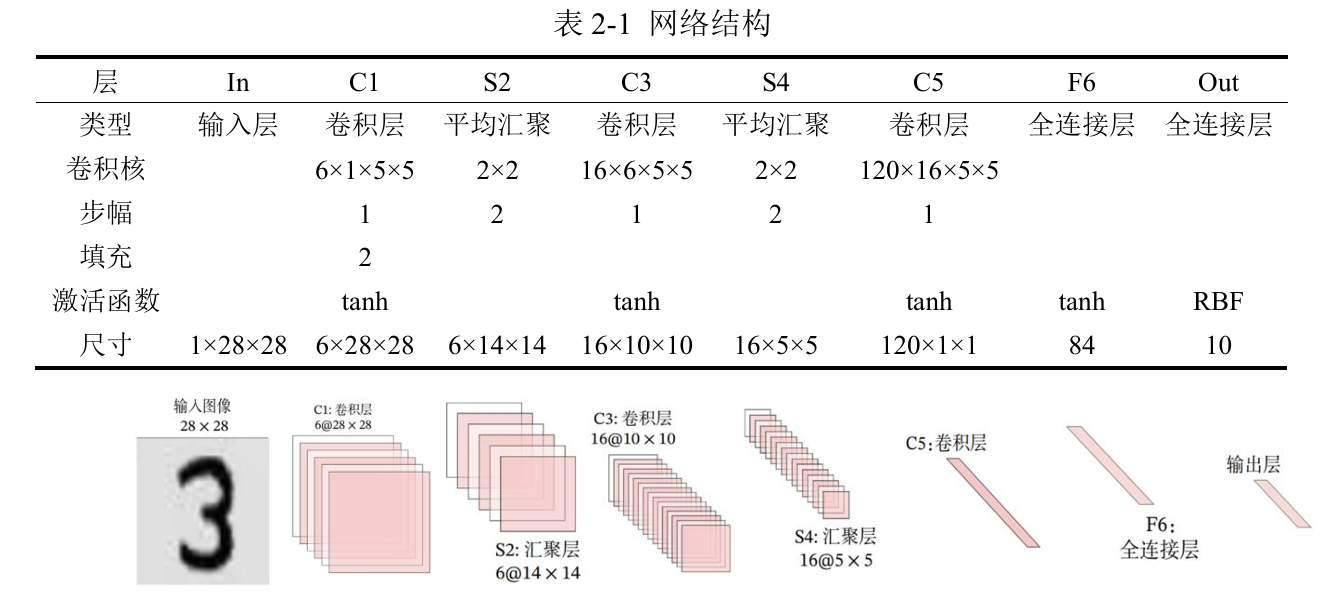

In [3]:
# 神经网络示意图
from IPython.display import Image

Image(filename='./images/LeNet 网络.png')

In [4]:
# 构造神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Tanh(),  # C1：卷积层
            nn.AvgPool2d(kernel_size=2, stride=2),  # S2：平均池化
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Tanh(),  # C3：卷积层
            nn.AvgPool2d(kernel_size=2, stride=2),  # S4：平均池化
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),  nn.Tanh(),  # C5：卷积层
            nn.Flatten(),  # 摊平
            nn.Linear(in_features=120, out_features=84), nn.Tanh(),  # F6：全链接层
            nn.Linear(in_features=84, out_features=10),  # 输出层
        )

    def forward(self, x):
        return self.net(x)

In [24]:
# 查看网络结构
X = torch.rand(size= (1, 1, 28, 28))
for layer in Net().net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Tanh output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Tanh output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Conv2d output shape: 	 torch.Size([1, 120, 1, 1])
Tanh output shape: 	 torch.Size([1, 120, 1, 1])
Flatten output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Tanh output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


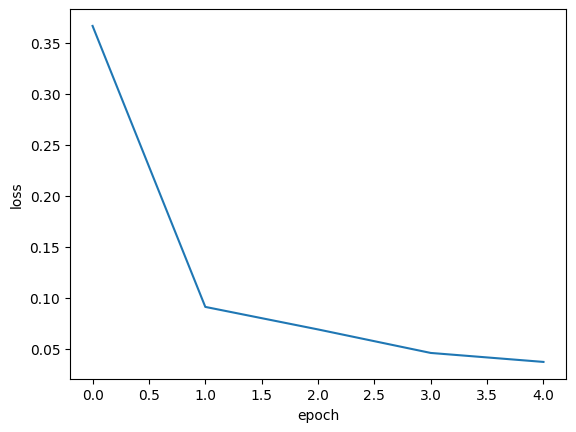

In [11]:
# 初始化网络与训练器
net = Net().to('cuda')

learning_rate = 0.9
loss_fn = nn.CrossEntropyLoss()  # 自带 softmax 激活函数

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

epochs = 5
losses = []

for epoch in range(epochs):
    avg_loss = 0
    times = 0
    
    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        times += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(avg_loss / times)

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [12]:
# 测试网络

correct = 0 
total = 0 

with torch.no_grad():          
    for (x, y) in test_loader:    
        # 获取小批次的x与y 
        x, y = x.to('cuda:0'), y.to('cuda:0') 
        Pred = net(x)       
        # 该局部关闭梯度计算功能 
        # 一次前向传播（小批量） 
        _, predicted = torch.max(Pred.data, dim=1) 
        correct += torch.sum((predicted == y))
        total += y.size(0)  
    
print(f'测试集精准度: {100 * correct/total} %')

测试集精准度: 98.40999603271484 %


In [20]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=58, height=58)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=58, height=58)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((28, 28)),  # 调整大小为28x28
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)